# Advanced Lane Finding (Project 2 - Self-Driving Car Engineer ND)

The goals / steps of this project are the following:

    * Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * Apply a distortion correction to raw images.
    * Use color transforms, gradients, etc., to create a thresholded binary image.
    * Apply a perspective transform to rectify binary image ("birds-eye view").
    * Detect lane pixels and fit to find the lane boundary.
    * Determine the curvature of the lane and vehicle position with respect to center.
    * Warp the detected lane boundaries back onto the original image.
    * Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Imports

In [146]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
import glob

test_image = plt.imread("test_images/test1.jpg")
plt.imsave("output_images/original_image.jpg", test_image)

## Camera Calibration


In [62]:
def calibrateCamera():
    """
    Calculates parameters needed for camera calibration with the help of the calibration files
    """
    # Load images from folder camera_cal with the help of the glob library
    images = glob.glob("camera_cal/calibration*.jpg")

    # Arrays to save object~ / image points from all images
    obj_points = []
    img_points = []

    # Preperation of objectpoints 
    objp = np.zeros((6*9,3), np.float32)
    for y in range(6):
        for x in range(9):
            objp[9*y+x] = [x,y,0]

    # Loop over all calibration images
    for image_path in images:
        # Read in image
        image = mpl_img.imread(image_path)

        # Convert Image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)

        if ret:
            img_points.append(corners)
            obj_points.append(objp)

    return obj_points, img_points

op, ip = calibrateCamera()

## Image distortion correction

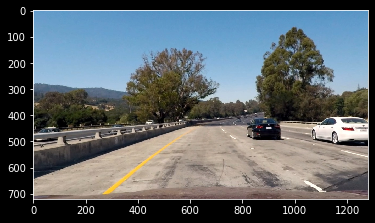

In [147]:
def undistortImage(image, o_points, i_points):
    """
    Undistort Images from a camera
    INPUT: distorted image, object_points, image_points (both from calibrateCamera())
    OUTPUT: undistorted image or error on failure
    """
    # Convert to gray scale
    #gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Calculate Camera matrix and distance coefficients 
    ret, cam_matrix, distance_coeff, rot_vec, trans_vec = cv2.calibrateCamera(o_points, i_points, gray.shape, None, None)
    if ret:
        # return undistorted image
        return cv2.undistort(image, cam_matrix, distance_coeff)
    else:
        # raise error if camera calibration fails
        raise ValueError("Can not undistort the given image!")

undistort_img = undistortImage(test_image, op, ip)
plt.imshow(undistort_img)
plt.imsave("output_images/undistorted_image.jpg", undistort_img)

## Thresholded binary image generation

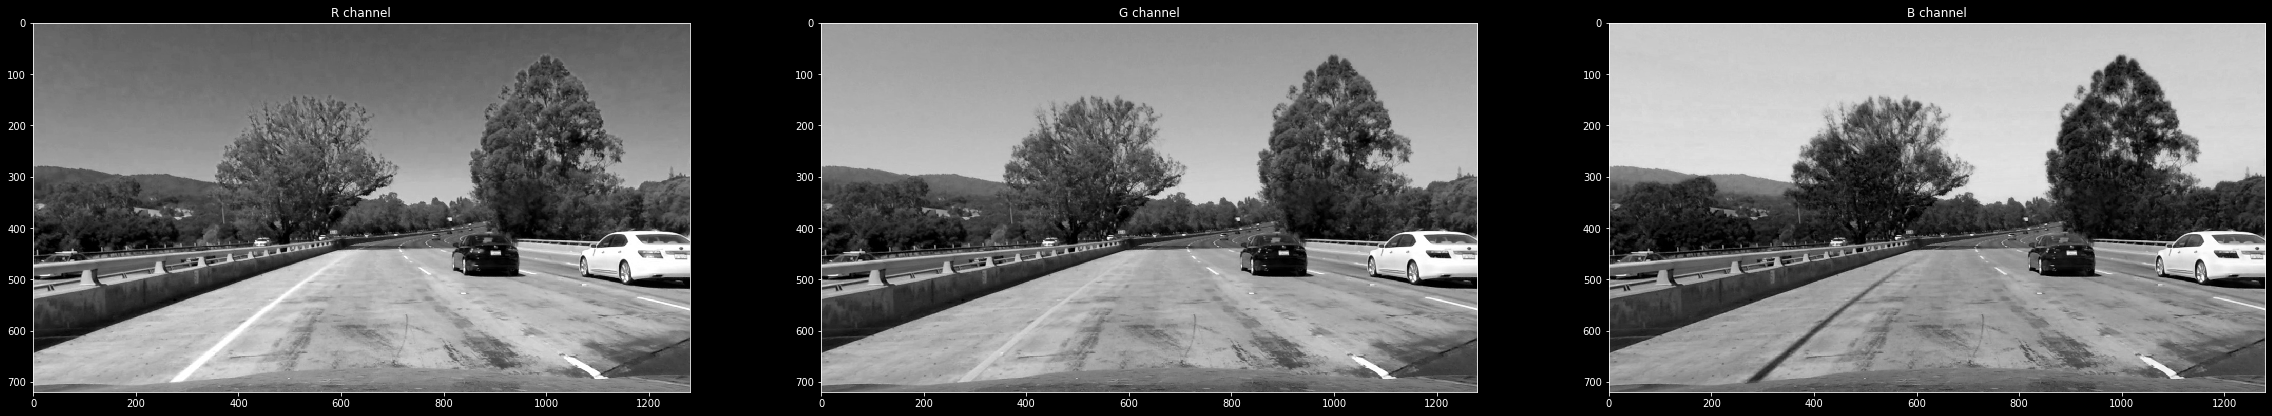

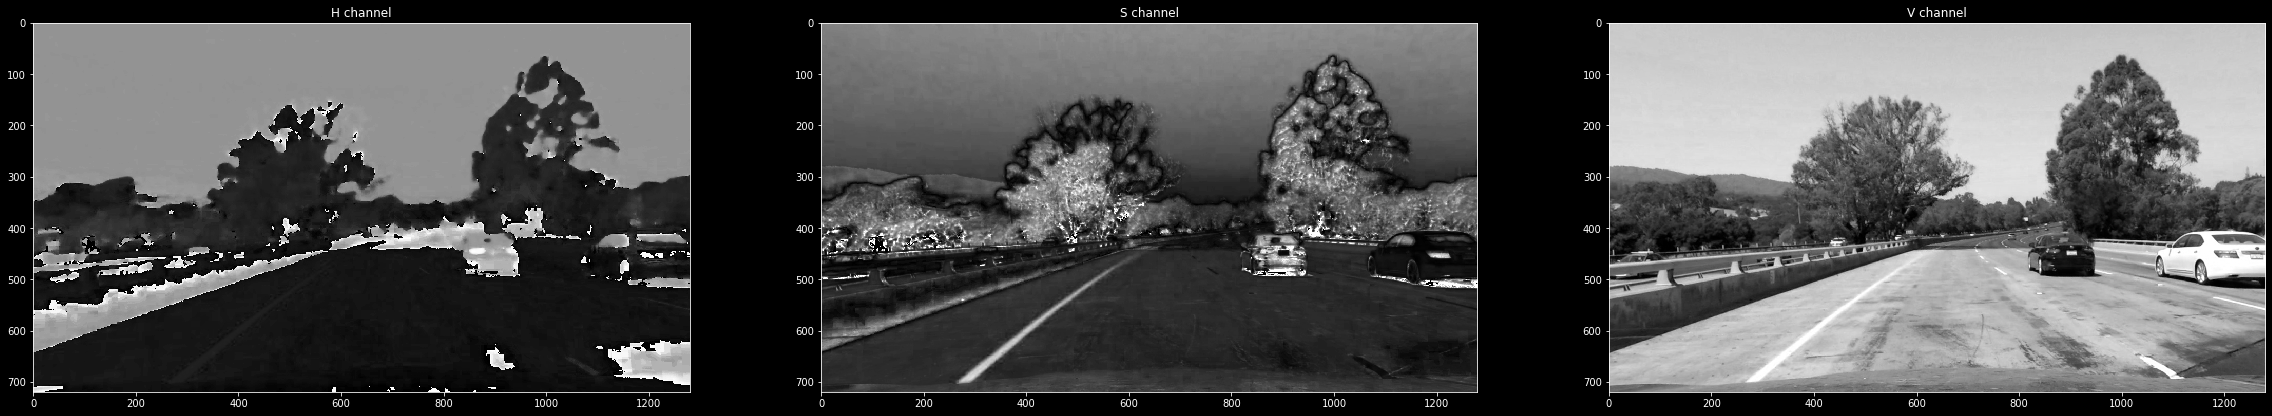

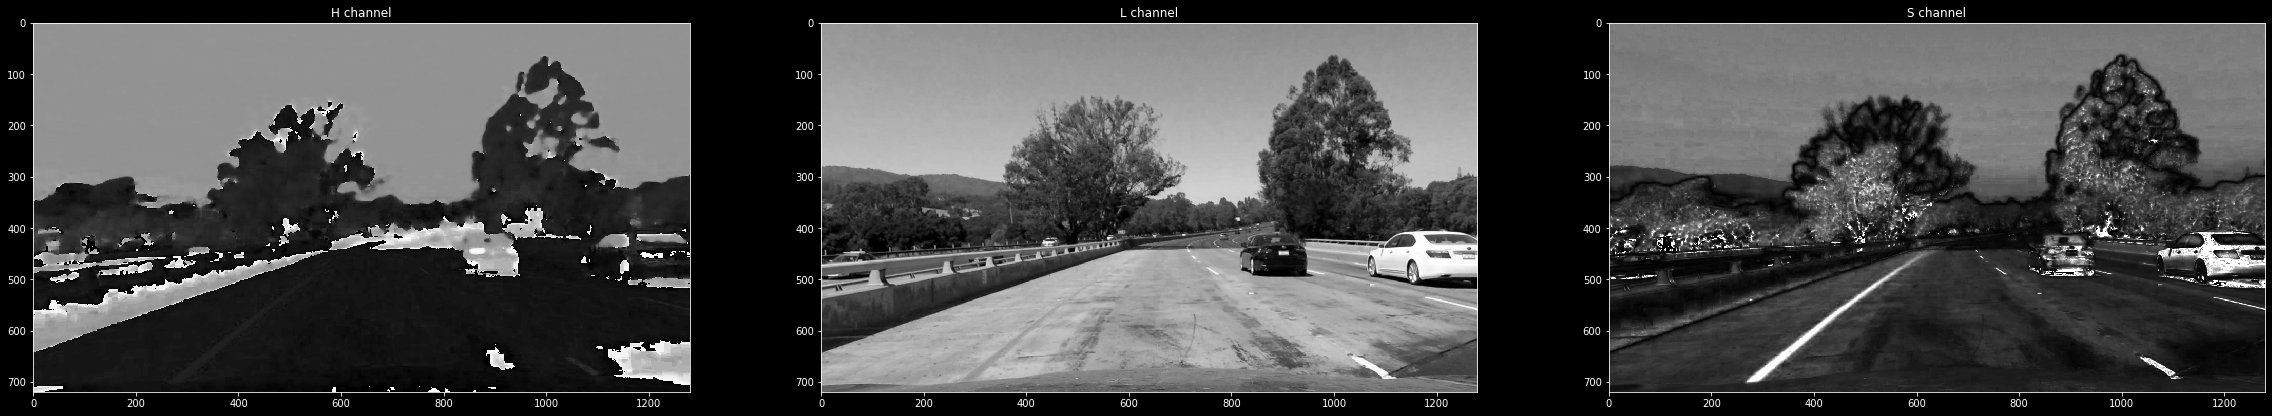

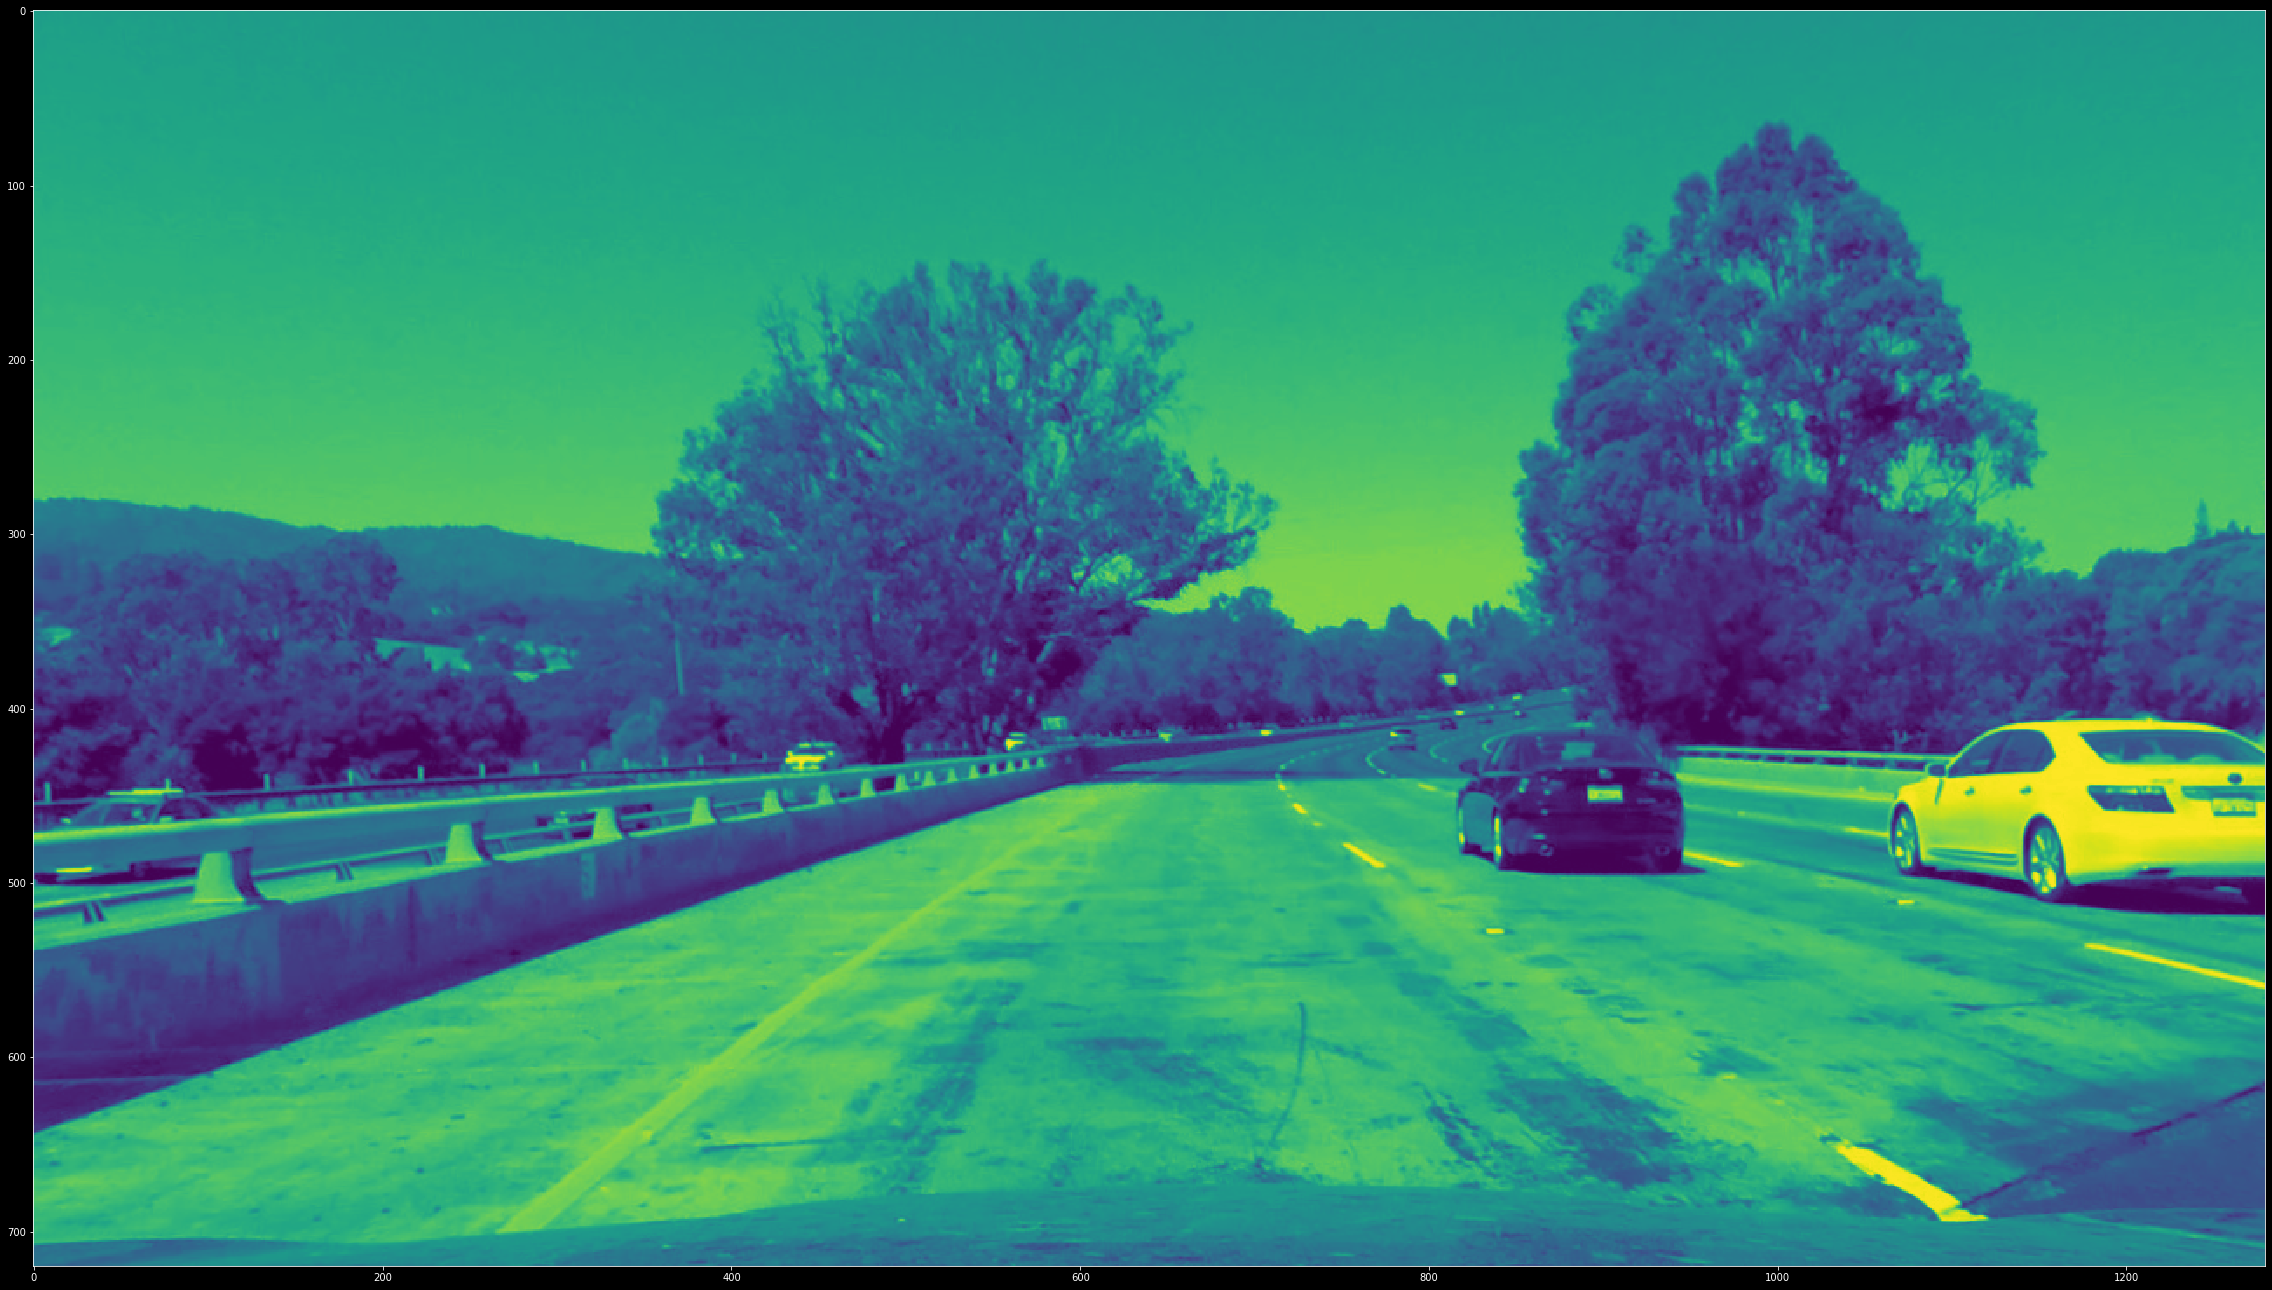

In [148]:
def show_channels(rgb_image):#
    """
    This function shows all channels from RGB, HSV and HSL images
    """
    r = rgb_image[:,:,0]
    g = rgb_image[:,:,1]
    b = rgb_image[:,:,2]
    
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)
    
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]

    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    
    red_image = np.copy(rgb_image)
    red_image[:,:,1] = 0
    red_image[:,:,2] = 0
    g_image = np.copy(rgb_image)
    g_image[:,:,0] = 0
    g_image[:,:,2] = 0
    b_image = np.copy(rgb_image)
    b_image[:,:,0] = 0
    b_image[:,:,1] = 0
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('R channel')
    ax1.imshow(r, cmap='gray')
    ax2.set_title('G channel')
    ax2.imshow(g, cmap='gray')
    ax3.set_title('B channel')
    ax3.imshow(b, cmap='gray')
    
    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(h, cmap='gray')
    ax2.set_title('S channel')
    ax2.imshow(s, cmap='gray')
    ax3.set_title('V channel')
    ax3.imshow(v, cmap='gray')

    f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(40,40))
    ax1.set_title('H channel')
    ax1.imshow(hls[:,:,0], cmap='gray')
    ax2.set_title('L channel')
    ax2.imshow(hls[:,:,1], cmap='gray')
    ax3.set_title('S channel')
    ax3.imshow(hls[:,:,2], cmap='gray')

    f, (ax1) = plt.subplots(1, 1, figsize=(40,40))
    ax1.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), cmap='gray')

show_channels(undistort_img)

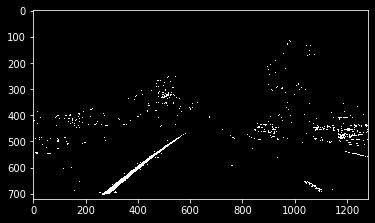

In [141]:
def create_thresholded_binary_image(rgb_image):
    """
    Function takes in an RGB image and returns an thresholded binary image with the lane lines 
    """
    # Image size
    xsize = rgb_image.shape[1]
    ysize = rgb_image.shape[0]

    # Thresholds
    lower_s_threshold = 160
    upper_s_threshold = 250
    lower_h_threshold = 19
    upper_h_threshold = 25

    # Color conversions
    hls = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HLS)
    s_hls = hls[:,:,2]
    h_hls = hls[:,:,0]
    h_hls[:int(2*ysize/3),:] = 0 # Had to remove some environment

    # Color thresholds
    s_threshold = (s_hls > lower_s_threshold) & (s_hls <= upper_s_threshold)
    h_threshold = (h_hls > lower_h_threshold) & (h_hls <= upper_h_threshold)
    color_based_threshold = (s_threshold | h_threshold)

    # Binary image creation
    binary = np.zeros_like(s_hls)
    binary[color_based_threshold] = 1

    plt.imshow(binary, cmap="gray")

create_thresholded_binary_image(undistort_img)